# Avoiding Overfitting in Image Classification

_By: Harsh Kumar, Gojek_  
_13th July 20204_  

Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Import libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Get training and validation data

We will be using CIFAR10 dataset which has images of 10 categories

In [3]:
batch_size = 4

Define transformations of input images  
- Convert data to tensors  
- Normalize values

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

NOTE: Shuffle has been turned off for training dataset as well.  
In this notebook, we want to use the same subset of images to train the model in every epoch, so that overfitting is clearly detectable

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

Name the classes which are part of the data

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

### Display sample images

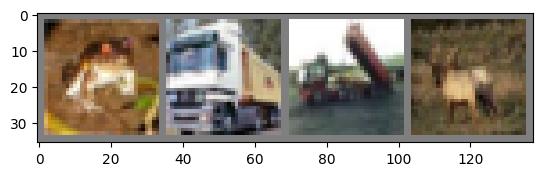

frog  truck truck deer 


In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define model structure

In [9]:
class ImgClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
model = ImgClassifier()
model.to(device)

ImgClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Train the Model

Define Optimizer and Loss Function

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

NOTE: Since shuffle is turned off, we will get images in the same sequence from trainloader. We will restrict the number of training images to first 8000 (2000 batches of 4 images each). This will allow us to clearly show overfitting

In [12]:
n_epochs = 20
train_batch_count = 2000

In [13]:
def train_model_batches(
    model: ImgClassifier,
    trainloader: torch.utils.data.DataLoader,
    batch_count: int
) -> (ImgClassifier, float):
    """
    Returns trained model for a fixed number of batches along with the training loss 
    """
    train_loss_cumm = 0.0
    for i, data_train in enumerate(trainloader, 0):
        # Start training
        model.train()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs_train, labels_train = data_train[0].to(device), data_train[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels_train_pred = model(inputs_train)
        loss = loss_fn(labels_train_pred, labels_train)
        loss.backward()
        optimizer.step()

        train_loss_cumm += loss.item()

        # stop training after batch count if reached
        if i == batch_count:    
            break

    # Loss value is calculated per batch
    return model, train_loss_cumm / batch_count

In [14]:
def get_val_loss(model: ImgClassifier, valloader: torch.utils.data.DataLoader) -> float:
    """
    Returns loss value on validation dataset for the given model
    """
    loss_val_total = 0
    
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data_val in enumerate(valloader, 0):
            inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)
            
            # Calculate predicted labels by running images through the network
            labels_pred_val = model(inputs_val)
            loss_val = loss_fn(labels_pred_val, labels_val)
            loss_val_total += loss_val.item()

    val_batch_count = i

    # Loss value is calculated per batch
    return loss_val_total / val_batch_count

In [15]:
train_loss_list=[]
val_loss_list=[]

# Loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.256 val_loss: 2.096
[2] loss: 1.912 val_loss: 1.713
[3] loss: 1.669 val_loss: 1.578
[4] loss: 1.537 val_loss: 1.497
[5] loss: 1.439 val_loss: 1.457
[6] loss: 1.359 val_loss: 1.429
[7] loss: 1.280 val_loss: 1.417
[8] loss: 1.203 val_loss: 1.411
[9] loss: 1.126 val_loss: 1.437
[10] loss: 1.042 val_loss: 1.489
[11] loss: 0.960 val_loss: 1.579
[12] loss: 0.880 val_loss: 1.675
[13] loss: 0.803 val_loss: 1.825
[14] loss: 0.755 val_loss: 2.006
[15] loss: 0.707 val_loss: 2.240
[16] loss: 0.680 val_loss: 2.254
[17] loss: 0.610 val_loss: 2.746
[18] loss: 0.545 val_loss: 2.644
[19] loss: 0.520 val_loss: 2.843
[20] loss: 0.539 val_loss: 2.653
Finished Training


### Plot Loss

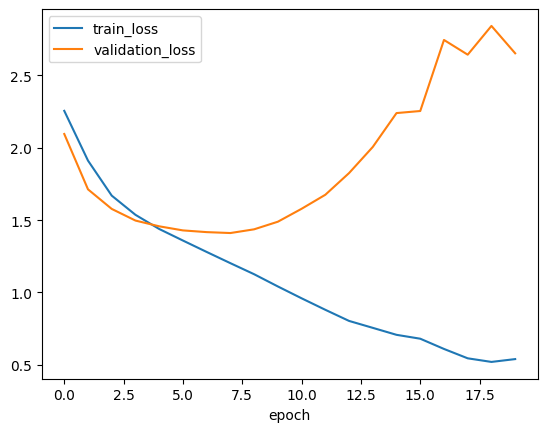

In [16]:
def plot_loss(train_loss_list, val_loss_list):
    df_loss = pd.DataFrame({"train_loss":train_loss_list, "validation_loss":val_loss_list})
    df_loss["epoch"] = df_loss.index
    
    axs = plt.subplot()
    df_loss.plot(x="epoch", y="train_loss", ax=axs)
    df_loss.plot(x="epoch", y="validation_loss", ax=axs)

plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [17]:
def get_accuracy_val_data(model: ImgClassifier, valloader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data_val in valloader:
            images, labels = data_val[0].to(device), data_val[1].to(device)
            # calculate outputs by running images through the network
            labels_pred = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(labels_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 45.92 %


## Early Stopping
Stop training when validation loss stops reducing 

Re-iniatialize model

In [18]:
model = ImgClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [19]:
# Path to store the model
MODEL_PATH = './cifar_model.pth'

Train the model

In [20]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}', end=" ")

    # Early Stopping Criteria
    # No need to check early checking criteria till we have atleast 3 epochs
    if len(val_loss_list)<3:
        print("-> Nothing to do")
    elif val_loss_list[-1] < val_loss_list[-2]:
        # Save the model if there is a reduction in loss on val data
        torch.save(model.state_dict(), MODEL_PATH)
        print("-> Saved Model")
    elif (val_loss_list[-1] >= val_loss_list[-2]) and (val_loss_list[-2] >= val_loss_list[-3]):
        print("-> Early Stopping")
        break
    else:
        print("-> Nothing to do")

print('Finished Training')

[1] loss: 2.234 val_loss: 1.966 -> Nothing to do
[2] loss: 1.856 val_loss: 1.724 -> Nothing to do
[3] loss: 1.687 val_loss: 1.604 -> Saved Model
[4] loss: 1.576 val_loss: 1.548 -> Saved Model
[5] loss: 1.491 val_loss: 1.489 -> Saved Model
[6] loss: 1.404 val_loss: 1.466 -> Saved Model
[7] loss: 1.325 val_loss: 1.445 -> Saved Model
[8] loss: 1.247 val_loss: 1.455 -> Nothing to do
[9] loss: 1.166 val_loss: 1.477 -> Early Stopping
Finished Training


### Plot Loss

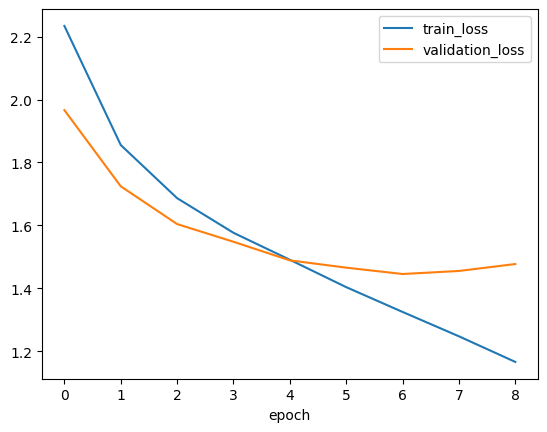

In [21]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [22]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [23]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 47.87 %


## Dropout
Randomly ignoring a fraction of neurons during training  
Pytorch Documentation: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

Define model with Dropout

In [24]:
class ImgClassifierDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [25]:
model = ImgClassifierDropout()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model

In [26]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.222 val_loss: 2.033
[2] loss: 1.924 val_loss: 1.793
[3] loss: 1.765 val_loss: 1.698
[4] loss: 1.678 val_loss: 1.636
[5] loss: 1.615 val_loss: 1.612
[6] loss: 1.563 val_loss: 1.584
[7] loss: 1.525 val_loss: 1.551
[8] loss: 1.486 val_loss: 1.530
[9] loss: 1.447 val_loss: 1.548
[10] loss: 1.417 val_loss: 1.501
[11] loss: 1.393 val_loss: 1.544
[12] loss: 1.375 val_loss: 1.515
[13] loss: 1.342 val_loss: 1.513
[14] loss: 1.316 val_loss: 1.501
[15] loss: 1.296 val_loss: 1.521
[16] loss: 1.287 val_loss: 1.524
[17] loss: 1.275 val_loss: 1.480
[18] loss: 1.244 val_loss: 1.553
[19] loss: 1.230 val_loss: 1.541
[20] loss: 1.220 val_loss: 1.541
Finished Training


### Plot Loss

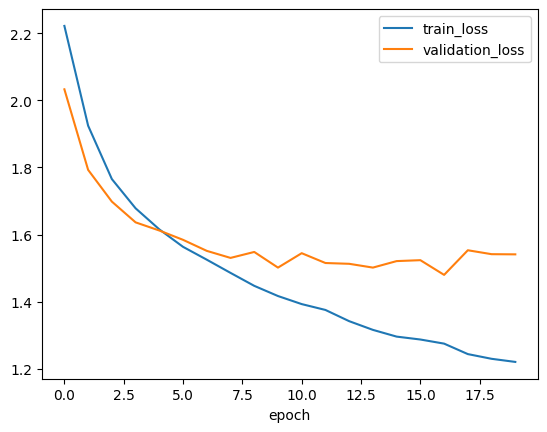

In [27]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [28]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 47.40 %


## L2 Regularization

Pytorch only offers L2 regularization out of the box through a `weight_decay` parameter for most of the optimizers

Reusing the earlier model, but with an updated optimizer

In [29]:
model = ImgClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

Train the model

In [30]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.285 val_loss: 2.165
[2] loss: 2.020 val_loss: 1.859
[3] loss: 1.799 val_loss: 1.675
[4] loss: 1.656 val_loss: 1.590
[5] loss: 1.572 val_loss: 1.532
[6] loss: 1.516 val_loss: 1.503
[7] loss: 1.472 val_loss: 1.474
[8] loss: 1.434 val_loss: 1.456
[9] loss: 1.400 val_loss: 1.444
[10] loss: 1.371 val_loss: 1.437
[11] loss: 1.345 val_loss: 1.432
[12] loss: 1.322 val_loss: 1.432
[13] loss: 1.298 val_loss: 1.424
[14] loss: 1.273 val_loss: 1.433
[15] loss: 1.249 val_loss: 1.436
[16] loss: 1.222 val_loss: 1.433
[17] loss: 1.198 val_loss: 1.442
[18] loss: 1.170 val_loss: 1.447
[19] loss: 1.143 val_loss: 1.457
[20] loss: 1.118 val_loss: 1.478
Finished Training


### Plot Loss

**NOTE: The gain from batch normalization seems to be low, probably due to very small batch size (4).  
Small batch sizes can result in inaccurate estimation of mean and standard deviation**

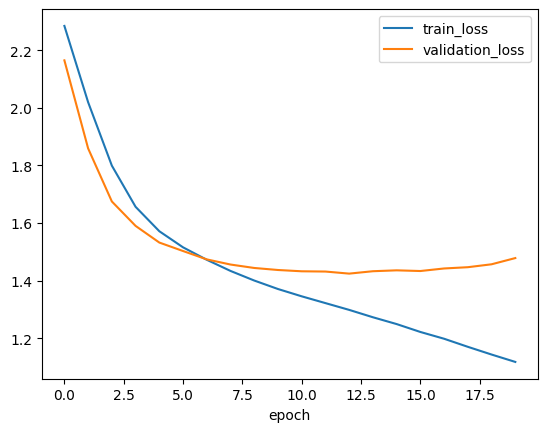

In [31]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [32]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 48.13 %


## Batch Normalization
Batch Normalization (BatchNorm) is a technique to improve training stability and speed up convergence. It involves normalizing the inputs to a layer in a neural network by scaling the activations. The normalization is performed across a mini-batch of data during training.

- Pytorch Documentation for Normalization Layers: https://pytorch.org/docs/stable/nn.html#normalization-layers
- Pytorch Documentation for BatchNorm1d: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d

Define model with Batch Normalization

In [33]:
class ImgClassifierBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.bn3(F.relu(self.fc1(x)))
        x = self.bn4(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [34]:
model = ImgClassifierBatchNorm()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model

In [35]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.157 val_loss: 2.150
[2] loss: 2.102 val_loss: 2.040
[3] loss: 2.036 val_loss: 1.975
[4] loss: 1.986 val_loss: 2.013
[5] loss: 2.007 val_loss: 1.964
[6] loss: 1.907 val_loss: 1.921
[7] loss: 1.847 val_loss: 1.888
[8] loss: 1.809 val_loss: 1.921
[9] loss: 1.810 val_loss: 1.914
[10] loss: 1.764 val_loss: 1.884
[11] loss: 1.758 val_loss: 1.896
[12] loss: 1.735 val_loss: 1.872
[13] loss: 1.669 val_loss: 1.880
[14] loss: 1.648 val_loss: 1.890
[15] loss: 1.613 val_loss: 1.891
[16] loss: 1.596 val_loss: 1.972
[17] loss: 1.615 val_loss: 1.904
[18] loss: 1.552 val_loss: 1.910
[19] loss: 1.501 val_loss: 1.938
[20] loss: 1.470 val_loss: 1.949
Finished Training


### Plot Loss

**NOTE: The gain from batch normalization seems to be low, probably due to very small batch size (4).  
Small batch sizes can result in inaccurate estimation of mean and standard deviation**

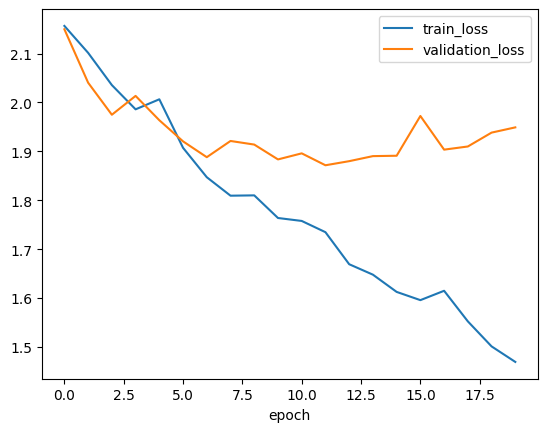

In [36]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [37]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 33.84 %


## Data Augmentation

### Demonstrate data augmentation

Show Original Images

frog  truck truck deer 


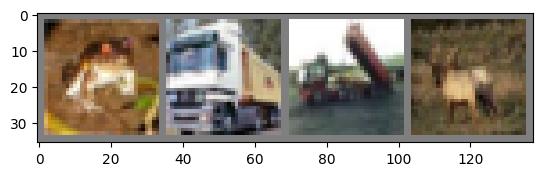

In [38]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# print labels and show images
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
imshow(torchvision.utils.make_grid(images))

Show transformed images

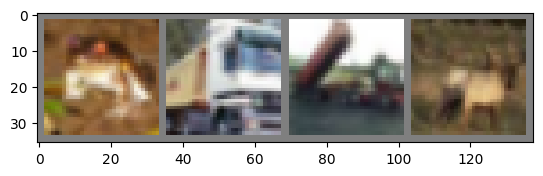

In [39]:
# Define transformations
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(32, 32), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=[random(), random(), random()], std=[random(), random(), random()]),
])

# show images
imshow(torchvision.utils.make_grid(transforms(images)))

### Training the model with augmented data

Reusing the earlier model

In [40]:
model = ImgClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model

In [41]:
def actual_train(inputs, labels_train):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    labels_train_pred = model(inputs)
    loss = loss_fn(labels_train_pred, labels_train)
    loss.backward()
    optimizer.step()

    return loss.item()

In [42]:
def train_model_batches_augment(
    model: ImgClassifier,
    trainloader: torch.utils.data.DataLoader,
    batch_count: int
) -> (ImgClassifier, float):
    """
    Returns trained model for a fixed number of batches along with the training loss 
    """
    train_loss_cumm = 0.0
    for i, data_train in enumerate(trainloader, 0):
        # Start training
        model.train()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs_train, labels_train = data_train[0].to(device), data_train[1].to(device)

        # train with original images
        train_loss_cumm += actual_train(inputs_train, labels_train)

        # train with randomly transformed images a few times
        for k in range(2):
            transforms = v2.Compose([
                v2.RandomResizedCrop(size=(32, 32), antialias=True),
                v2.RandomHorizontalFlip(p=0.5),
                # v2.ToDtype(torch.float32, scale=True),
                # v2.Normalize(mean=[random(), random(), random()], std=[random(), random(), random()]),
            ])
            train_loss_cumm += actual_train(transforms(inputs_train), labels_train)

        # stop training after batch count if reached
        if i == batch_count:    
            break

    # Loss value is calculated per batch
    return model, train_loss_cumm / (batch_count*(1+2))

In [43]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches_augment(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.095 val_loss: 1.871
[2] loss: 1.857 val_loss: 1.714
[3] loss: 1.755 val_loss: 1.688
[4] loss: 1.693 val_loss: 1.630
[5] loss: 1.657 val_loss: 1.589
[6] loss: 1.614 val_loss: 1.484
[7] loss: 1.577 val_loss: 1.558
[8] loss: 1.547 val_loss: 1.526
[9] loss: 1.517 val_loss: 1.495
[10] loss: 1.491 val_loss: 1.442
[11] loss: 1.470 val_loss: 1.450
[12] loss: 1.449 val_loss: 1.445
[13] loss: 1.430 val_loss: 1.456
[14] loss: 1.406 val_loss: 1.485
[15] loss: 1.396 val_loss: 1.473
[16] loss: 1.369 val_loss: 1.449
[17] loss: 1.370 val_loss: 1.476
[18] loss: 1.355 val_loss: 1.443
[19] loss: 1.338 val_loss: 1.507
[20] loss: 1.330 val_loss: 1.474
Finished Training


### Plot Loss

**NOTE: The gain from batch normalization seems to be low, probably due to very small batch size (4).  
Small batch sizes can result in inaccurate estimation of mean and standard deviation**

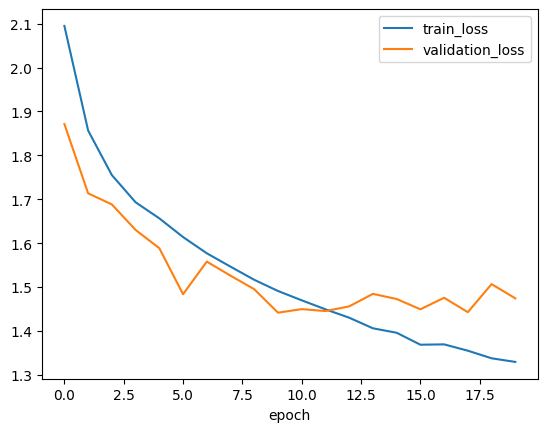

In [44]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [45]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 51.11 %


## Gradient Clipping
https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html

Reusing the earlier model

In [46]:
model = ImgClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model

In [47]:
def train_model_batches_gradient_clip(
    model: ImgClassifier,
    trainloader: torch.utils.data.DataLoader,
    batch_count: int
) -> (ImgClassifier, float):
    """
    Returns trained model for a fixed number of batches along with the training loss 
    """
    train_loss_cumm = 0.0
    for i, data_train in enumerate(trainloader, 0):
        # Start training
        model.train()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs_train, labels_train = data_train[0].to(device), data_train[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels_train_pred = model(inputs_train)
        loss = loss_fn(labels_train_pred, labels_train)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss_cumm += loss.item()

        # stop training after batch count if reached
        if i == batch_count:    
            break

    # Loss value is calculated per batch
    return model, train_loss_cumm / batch_count

In [48]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches_gradient_clip(model, trainloader, train_batch_count)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.175 val_loss: 2.045
[2] loss: 2.009 val_loss: 1.982
[3] loss: 1.936 val_loss: 1.908
[4] loss: 1.849 val_loss: 1.835
[5] loss: 1.772 val_loss: 1.771
[6] loss: 1.712 val_loss: 1.718
[7] loss: 1.667 val_loss: 1.679
[8] loss: 1.632 val_loss: 1.651
[9] loss: 1.604 val_loss: 1.628
[10] loss: 1.581 val_loss: 1.609
[11] loss: 1.559 val_loss: 1.591
[12] loss: 1.540 val_loss: 1.576
[13] loss: 1.520 val_loss: 1.560
[14] loss: 1.501 val_loss: 1.544
[15] loss: 1.481 val_loss: 1.526
[16] loss: 1.460 val_loss: 1.512
[17] loss: 1.439 val_loss: 1.497
[18] loss: 1.420 val_loss: 1.486
[19] loss: 1.403 val_loss: 1.477
[20] loss: 1.387 val_loss: 1.468
Finished Training


### Plot Loss

**NOTE: The gain from batch normalization seems to be low, probably due to very small batch size (4).  
Small batch sizes can result in inaccurate estimation of mean and standard deviation**

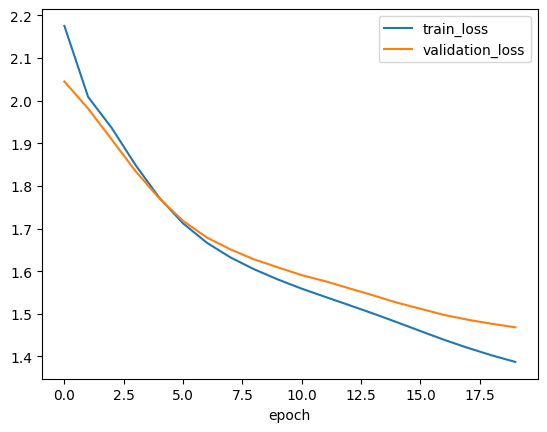

In [49]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [50]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 47.81 %
